In [3]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from utils import clear_data, encode_data, conf_matrix, evaluate_metrics

warnings.filterwarnings('ignore')

## Data preparation

In [4]:
data = pd.read_csv("data/train_users_processed.csv")
test_data = pd.read_csv("data/test_users.csv")

In [5]:
df = encode_data(data)
cat_type = CategoricalDtype(df["country_destination"].unique(), ordered=True)
df["country_destination"] = df["country_destination"].astype(cat_type).cat.codes

In [6]:
cleared_test_data = clear_data(test_data)
test_df = encode_data(cleared_test_data)

In [7]:
X = df.drop(["country_destination"], axis=1)
y = df["country_destination"]

cols_not_in_test = set(X).difference(set(test_df.columns))
cols_not_in_X = set(test_df).difference(set(X.columns))

# dealing with missing unique values in both dataframes

for col in cols_not_in_test:
    test_df[col] = 0
    
for col in cols_not_in_X:
    X[col] = 0
    
test_df.columns = X.columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)  #for conf matrix computation


# computes metrics (using CV with 5 folds) and prints confusion matrix for separate part of data
def show_perfomance(estimator, X, X_train_xx, y, y_train_xx):
    evaluate_metrics(estimator, X, y)
    
    estimator.fit(X_train_xx, y_train_xx)
    y_pred = estimator.predict(X_test)
    conf_matrix(y_test, y_pred)

### Base tree model training

Accuracy: 0.6434252554068223
Precision: 0.2374092741483725
Recall: 0.1610189059614997
F1: 0.17794333668597853


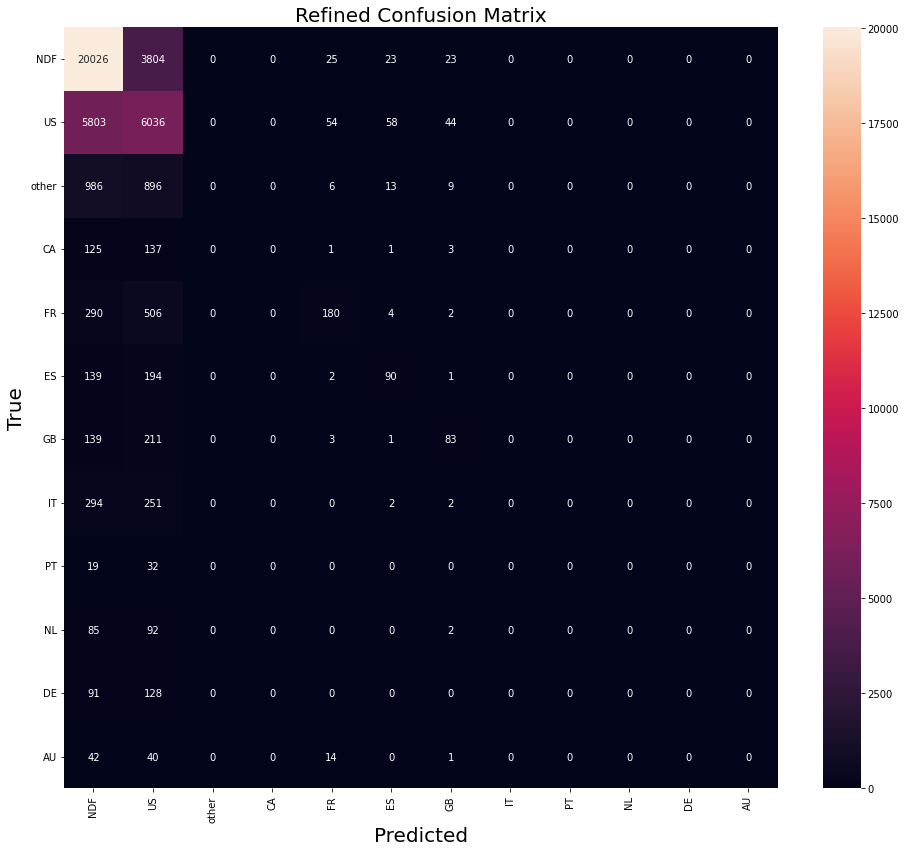

In [6]:
tree = DecisionTreeClassifier(max_depth=8, criterion="entropy")
show_perfomance(tree, X, X_train, y, y_train)

In [7]:
weights = {0: 1,
           1: 1,
           2: 1,
           4: 1,
           7: 1,
           6: 1,
           5: 1,
           3: 1,
           10: 1,
           9: 1,
           11: 1,
           8: 1}

Accuracy: 0.6429229756418696
Precision: 0.23732885038837703
Recall: 0.16068924577571986
F1: 0.17762344563419902


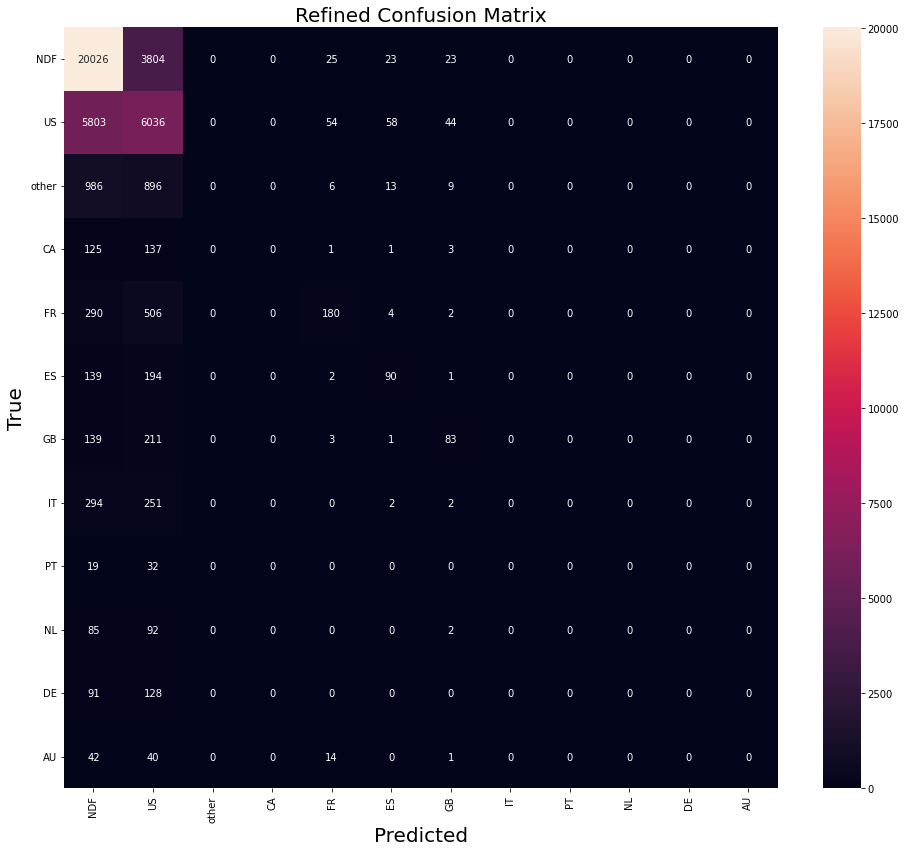

In [8]:
tree_weigths = DecisionTreeClassifier(max_depth=8, criterion="entropy", class_weight=weights)
show_perfomance(tree_weigths, X, X_train, y, y_train)

### Tree model with random oversampling

In [9]:
strategy_over = {3: 15000,
                 4: 15000,
                 5: 15000,
                 6: 15000,
                 7: 15000,
                 8: 15000,
                 9: 15000,
                 10: 15000,
                 11: 15000}

ros = RandomOverSampler(sampling_strategy=strategy_over)
X_os, y_os = ros.fit_resample(X, y)
X_train_os, y_train_os = ros.fit_resample(X_train, y_train)

Accuracy: 0.4406213953850151
Precision: 0.36814721354330393
Recall: 0.18906546385486753
F1: 0.19606970577853877


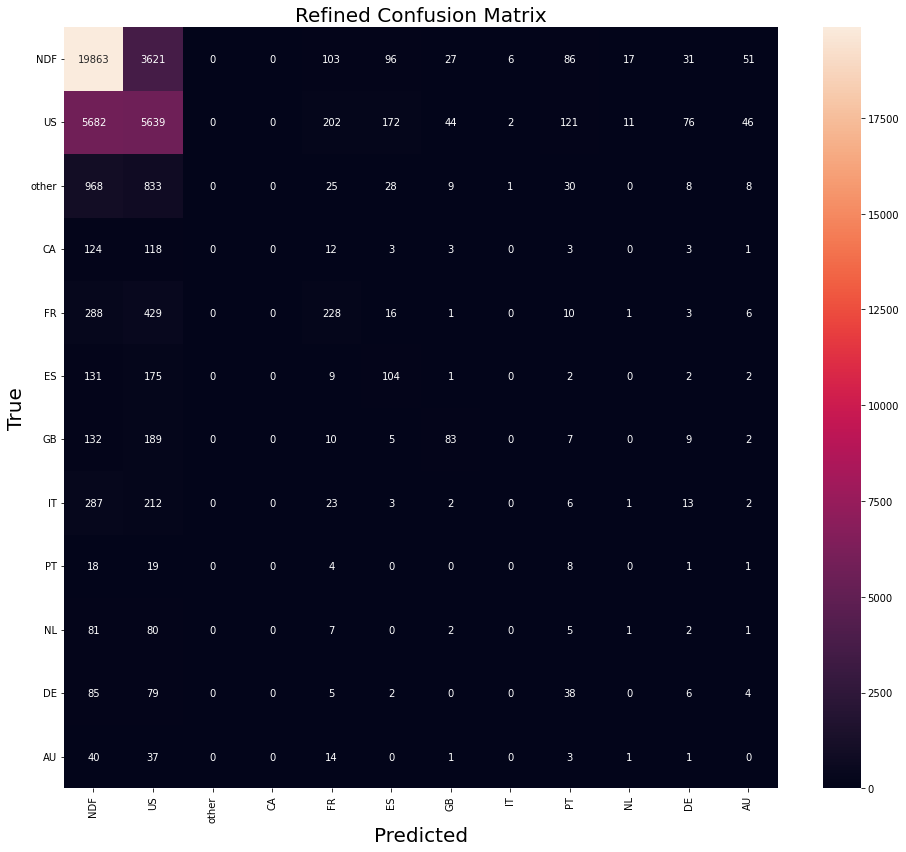

In [10]:
tree_os = DecisionTreeClassifier(max_depth=8, criterion="entropy")

show_perfomance(tree_os, X_os, X_train_os, y_os, y_train_os)

del X_os, y_os, X_train_os, y_train_os, tree_os

### Tree model with undersampling

In [11]:
strategy_under = {0: 60000,
                  1: 30000}

rus = RandomUnderSampler(sampling_strategy=strategy_under)
X_us, y_us = rus.fit_resample(X, y)
X_train_us, y_train_us = rus.fit_resample(X_train, y_train)

Accuracy: 0.5815674086847155
Precision: 0.2889785856150301
Recall: 0.1736143435861283
F1: 0.19231791284306765


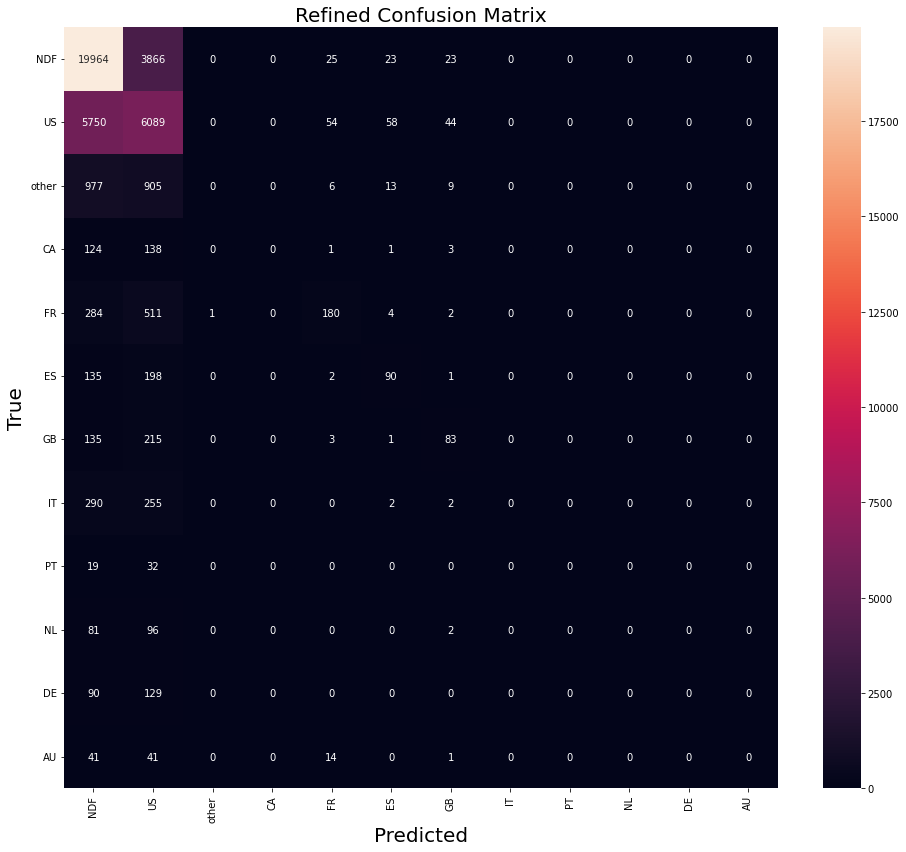

In [12]:
tree_us = DecisionTreeClassifier(max_depth=8, criterion="entropy")

show_perfomance(tree_us, X_us, X_train_us, y_us, y_train_us)

del X_us, y_us, X_train_us, y_train_us, tree_us

### Tree model with oversampling using SMOTE

In [13]:
strategy_smote = {3: 25000,
                  4: 25000,
                  5: 25000,
                  6: 25000,
                  7: 25000,
                  8: 25000,
                  9: 25000,
                  10: 25000,
                  11: 25000}

smote = SMOTENC(categorical_features=list(range(1, len(X.columns))),sampling_strategy=strategy_smote)
X_sm, y_sm = smote.fit_resample(X, y)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

Accuracy: 0.37481107064430047
Precision: 0.40298725299096894
Recall: 0.19950385737952755
F1: 0.19978764290266177


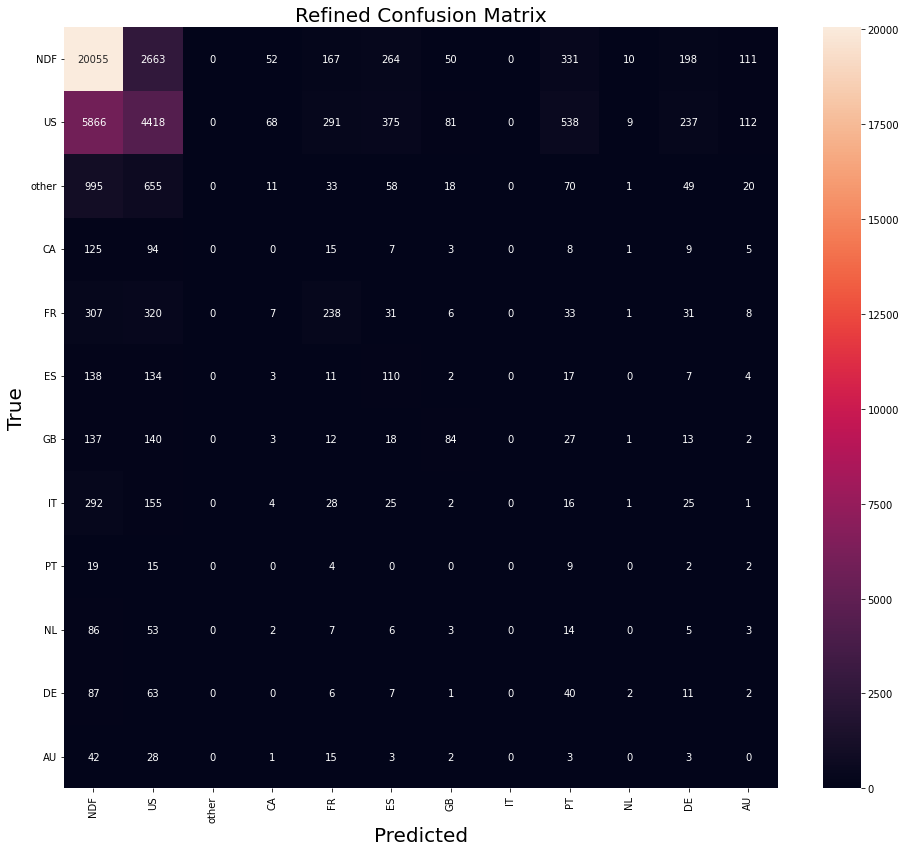

In [14]:
tree_sm = DecisionTreeClassifier(max_depth=8, criterion="entropy")

show_perfomance(tree_sm, X_sm, X_train_sm, y_sm, y_train_sm)

del X_sm, y_sm, X_train_sm, y_train_sm, tree_sm

### Tree model with undersampling using NearMiss

In [15]:
strategy_nearmiss = {0: 50000,
                     1: 30000}

nm = NearMiss(sampling_strategy=strategy_nearmiss)
X_nm, y_nm = nm.fit_resample(X, y)
X_train_nm, y_train_nm = nm.fit_resample(X_train, y_train)

Accuracy: 0.5900310460134663
Precision: 0.3050614692771466
Recall: 0.18475276436737398
F1: 0.20435458316324734


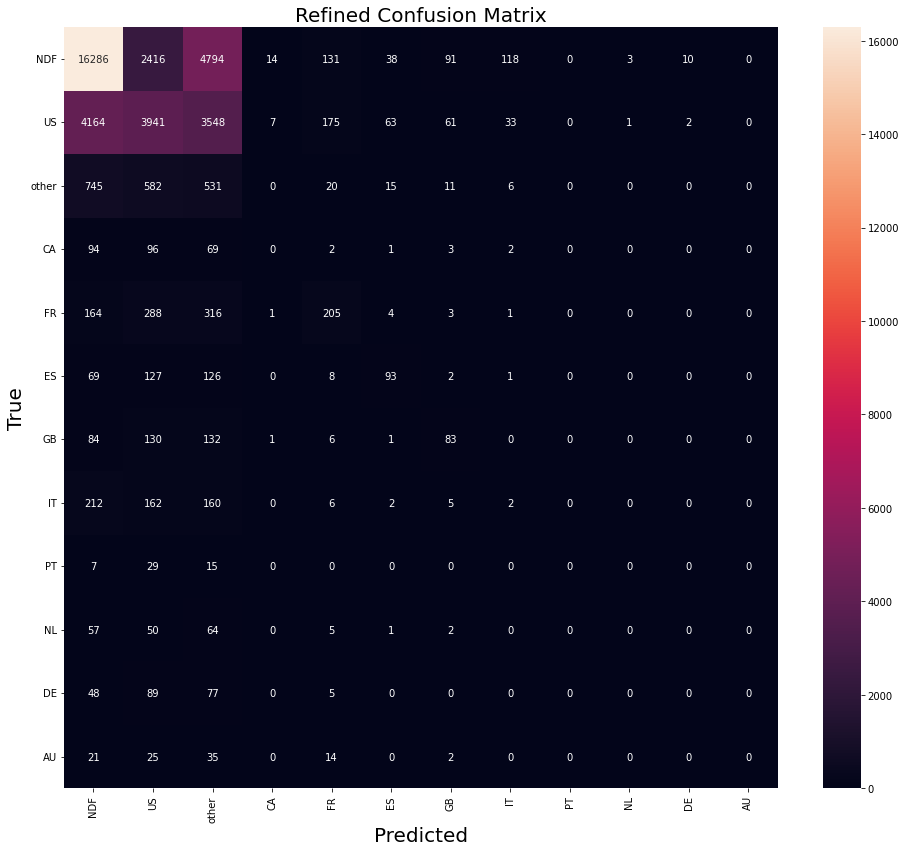

In [16]:
tree_nm = DecisionTreeClassifier(max_depth=8, criterion="entropy")

show_perfomance(tree_nm, X_nm, X_train_nm, y_nm, y_train_nm)

del X_nm, y_nm, X_train_nm, y_train_nm, tree_nm

### Tree OnevsRest model training

Accuracy: 0.6435081559505522
Precision: 0.24564546103477505
Recall: 0.16101707043365307
F1: 0.17792004072234344


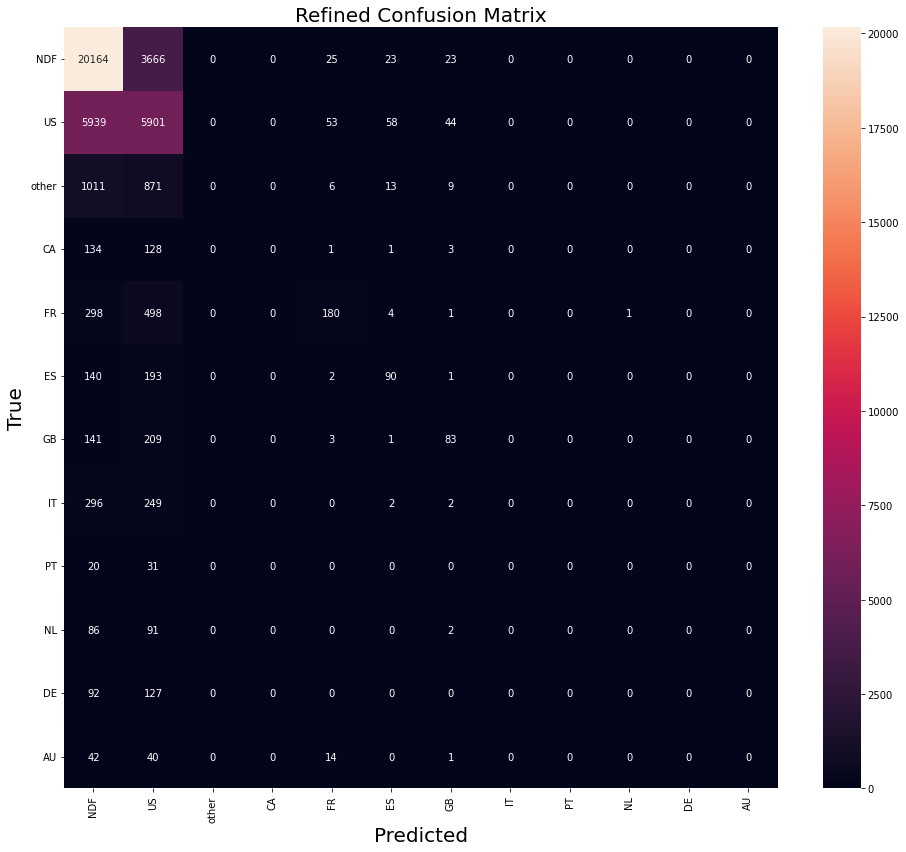

In [17]:
tree_ovr = OneVsRestClassifier(DecisionTreeClassifier(max_depth=7, criterion="entropy"))

show_perfomance(tree_ovr, X, X_train, y, y_train)

del tree_ovr

### Random forest model training

In [18]:
from sklearn.ensemble import RandomForestClassifier

Accuracy: 0.642996123180455
Precision: 0.2547424348128671
Recall: 0.16026527988806485
F1: 0.1773348925907992


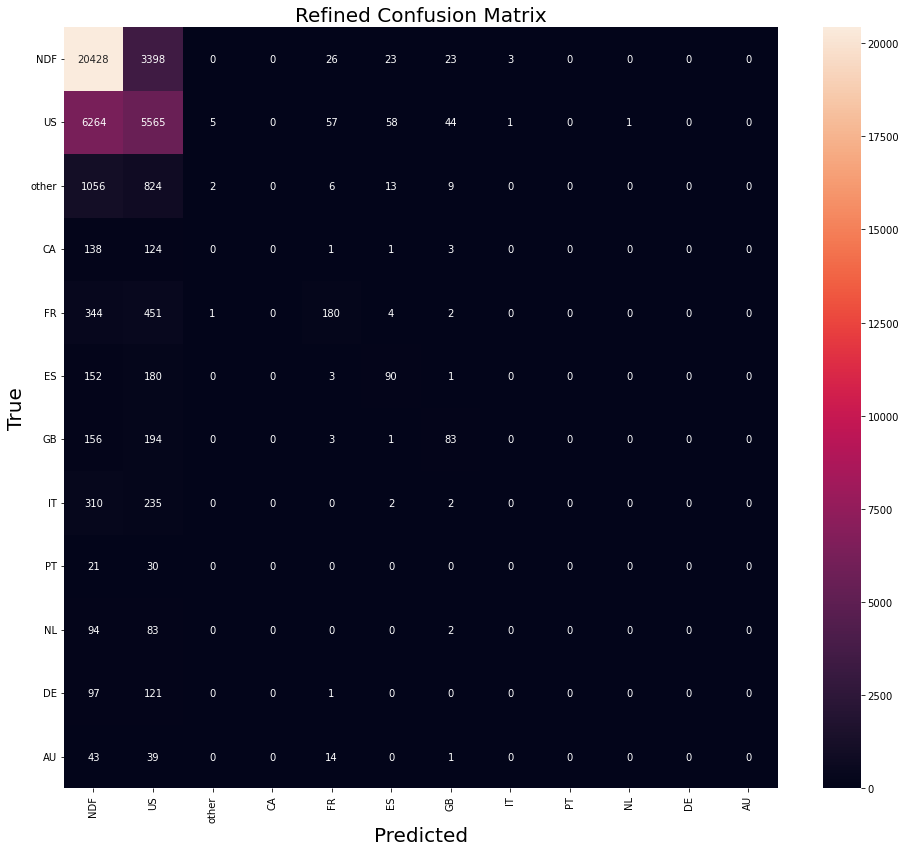

In [19]:
forest = RandomForestClassifier(n_estimators=100, max_depth=15, criterion="entropy")

show_perfomance(forest, X, X_train, y, y_train)

del forest

### XGBoost model training

In [20]:
from xgboost import XGBClassifier

Accuracy: 0.6437763635920317
Precision: 0.25437978136708644
Recall: 0.16064051772282006
F1: 0.17771687579169573


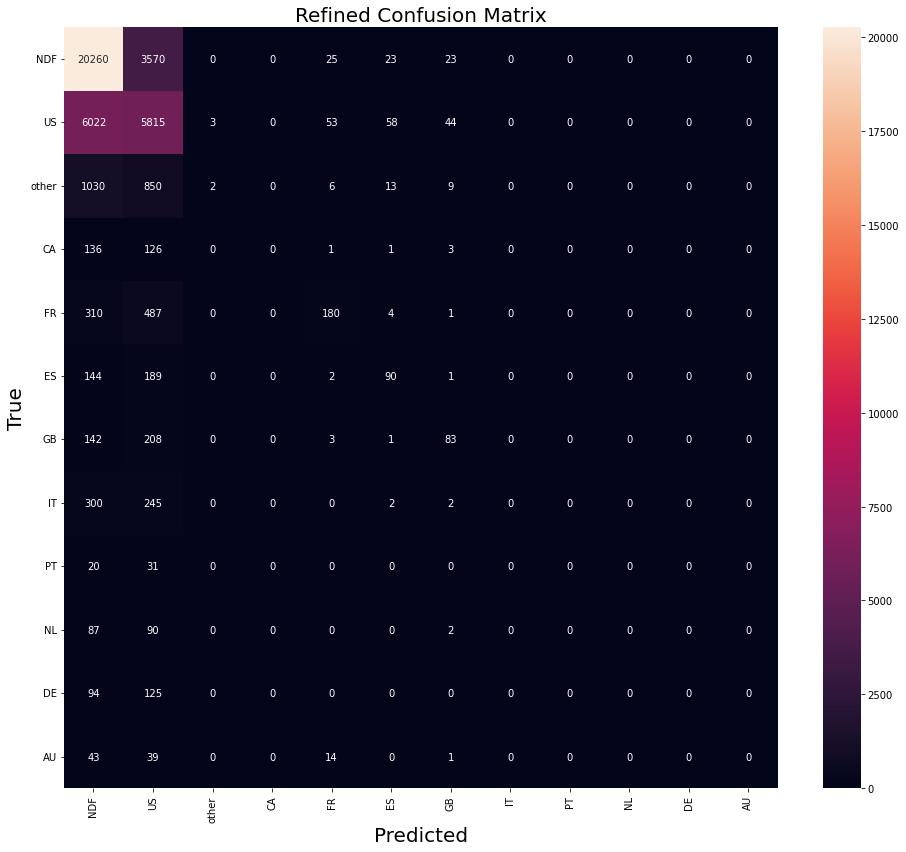

In [21]:
xgb_model = XGBClassifier(n_estimators=30, max_depth=6)

show_perfomance(xgb_model, X, X_train, y, y_train)

del xgb_model

### KNN model training

In [8]:
from sklearn.neighbors import KNeighborsClassifier

Accuracy: 0.545714773364543
Precision: 0.08226578408141492
Recall: 0.09349329574027211
F1: 0.08736527443934056


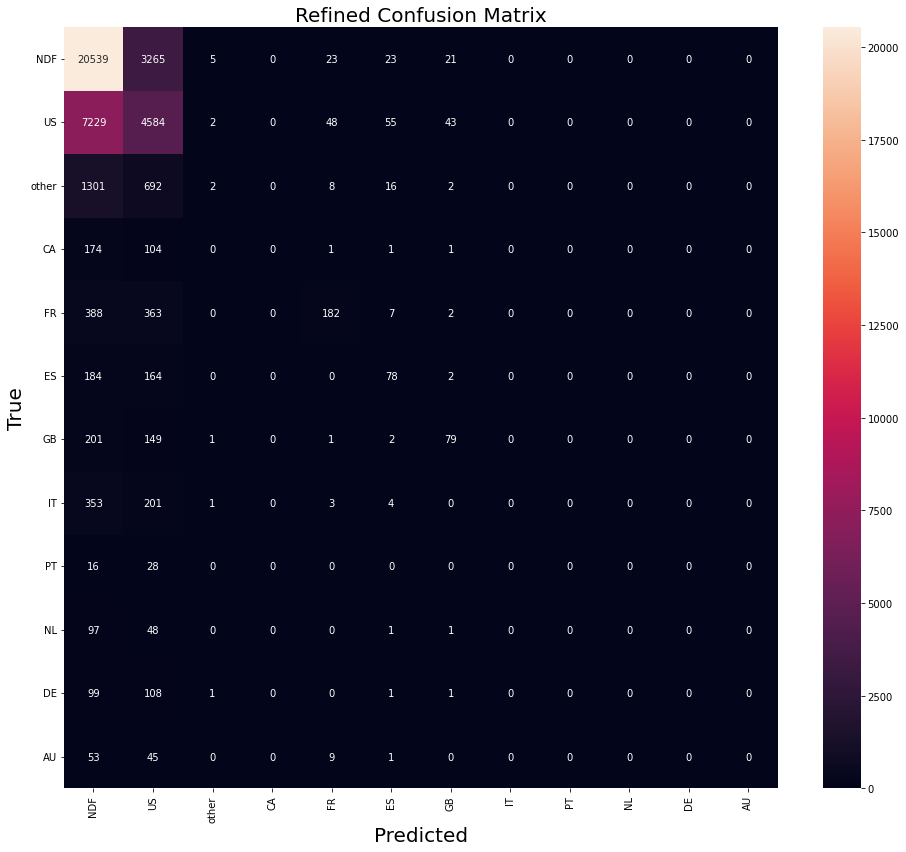

In [11]:
KNN = KNeighborsClassifier(n_neighbors=7)

show_perfomance(KNN, X, X_train, y, y_train)

del KNN

### Run model on test data

In [31]:
y_test_pred = tree.predict(test_df)
y_test_pred = pd.Series(y_test_pred)
categories = cat_type.categories

y_test_pred = y_test_pred.apply(lambda x: categories[x])

In [32]:
submission = pd.DataFrame({"id": test_data["id"], "country": y_test_pred})

In [33]:
submission.to_csv("submissions/submission_0.csv")